# Notebook for analysing simulation outputs

## Summary
* [1. Read & Process simulation outputs](#t1)
    * [1.1. Read PF_files](#t1_1)
    * [1.2. Read CLM_files](#t1_2)
* [2. Compute water budget](#t2)
    * [2.1. Precipitation](#t2_1)
    * [2.2. Evapotranspiration](#t2_2)    
    * [2.3. Runoff](#t2_3)
    * [2.4. storage](#t2_4)    
    * [2.5. Compute and plot](#t2_5)
* [3. Compute energy budget](#t3)
* [4. Compute & plot ET](#t4)
* [5. Compute & plot runoff](#t5)
* [6. Compute & plot WT](#t6)
* [7. Compute & plot soil moisture](#t7)
* [8. Compute & plot water storage](#t8)
* [9. Compute & plot retention curves](#t9)




## 1. Read & Process simulation outputs <a class="anchor" id="t1"></a>

In [1]:
import numpy as np
import os,glob,struct
import xarray as xr
import pandas as pd
import datetime as dt

from parflow import read_pfb, read_pfb_sequence, ParflowBinaryReader
from parflow import Run

### 1.1. Read PF files <a class="anchor" id="t1_1"></a>

native parflow format is .pfb, these are binary files with a header giving the parflow grid information and a matrix (1D,2D, or 3D). 

Either a simple function can be used to read a pfb file and its header, or one could use pftools libraries:

In [6]:
root_dir = '/home/hectorb/PARFLOW/cours/cours2024/hillslope_input_files/'
root_dir = '/home/hectorb/PARFLOW/PROJECTS/test_cases/hillslope/ara_bele/cours2023/'

#forc_dir = "/home/hectorb/PARFLOW/PROJECTS/test_cases/hillslope/forcings/soudanian/"
wdir = root_dir+'results_benchmark/'

#Access the header: 
with ParflowBinaryReader(glob.glob(wdir+'*.press.00000.pfb')[0]) as s: h = s.header

# h is the header of the first pressure output file (corresponding to initial conditions ('.00000.pfb'))

Two convenient functions are within pftools: read_pfb and read_pfb_sequence. The first one reads in a single file, and the second reads a temporal series of files.

The following function reads main ParFlow output files and store them within a DataSet (an xarray object which can easily be saved as a .netcdf afterwards)

In [7]:
def read_and_process_pf_outputs(wdir,date_start="2005-01-01"):
    # read header
    with ParflowBinaryReader(glob.glob(wdir+'*.press.00000.pfb')[0]) as s: h = s.header
    print(h)
    
    # get z
    var_dz = read_pfb(glob.glob(wdir+'*mult*.pfb')[0])
    var_dz_vec = var_dz[:,0,0]
    var_dz_vec = var_dz_vec[::-1]
    dz = var_dz_vec * h['dz']
    z = np.cumsum(dz) - var_dz_vec* h['dz']/2 
    
    # get pressure (pop(0) skips initial condition)
    files = np.sort(glob.glob(wdir+'*.press.*.pfb'))[1::]
    press = read_pfb_sequence(files)
    
    # get saturation
    files = np.sort(glob.glob(wdir+'*.satur.*.pfb'))[1::]
    satur = read_pfb_sequence(files)
    
    # get evaptranssum
    files = np.sort(glob.glob(wdir+'*.evaptranssum.*.pfb'))
    evaptranssum = read_pfb_sequence(files)
        
    # get overlandsum
    files = np.sort(glob.glob(wdir+'*.overlandsum.*.pfb'))
    overlandsum = read_pfb_sequence(files)
        
    # create dataset
    ds = xr.Dataset({"press": (("time","z","y"), press[:,::-1,:,0]),
                    "satur": (("time","z","y"), satur[:,::-1,:,0]),
                    "evaptranssum": (("time","z","y"), evaptranssum[:,::-1,:,0]),
                    "overlandsum":(("time","y"), overlandsum[:,0,:,0]),
                    'vdz': (("z","y"),var_dz[::-1,:,0])},
        coords={"x":np.arange(start = h['x'],stop = h['x']+h['nx']*h['dx'],step=h['dx']),
            "y":np.arange(start = h['y'],stop = h['y']+h['ny']*h['dy'],step=h['dy']),
            "z":-z, 
            "time": pd.date_range(date_start, periods=len(files)),
            "reference_time": pd.Timestamp(date_start)})

    # add WTD:
    ds = ds.assign(WTD = z[-1] - ds.press.isel(z=-1))

    # add auxiliary variables:
    ds = ds.assign(poro=(("z","y"),read_pfb(glob.glob(wdir+'*poro*.pfb')[0])[::-1,:,0]))
    ds = ds.assign(specstor=(("z","y"),read_pfb(glob.glob(wdir+'*specific*.pfb')[0])[::-1,:,0]))    

    # compute storage:
    ds = ds.assign(storage_cbyc=lambda x: h['dx']*h['dy']*h['dz']*x.satur*x.vdz*x.poro + \
                                        h['dx']*h['dy']*h['dz']*x.vdz*x.specstor*x.satur*x.press + \
                                        xr.where((x.z==x.z[0]) & (x.press>0),h['dx']*h['dy']*x.press,0))
    ds = ds.assign(storage=lambda x: x.storage_cbyc.sum(dim=('z')))

    ds = ds.assign(soil_moisture = lambda x: x.satur*x.poro)
    
    ds.press.attrs['units']='m'
    ds.satur.attrs['units']='m3/m3'
    ds.evaptranssum.attrs['units']='m3/PFtimestep'
    ds.overlandsum.attrs['units']='m3/PFtimestep' 
    ds.storage.attrs['units']='m3'
    ds.storage_cbyc.attrs['units']='m3'  
    ds.y.attrs['units']='meters'
    ds.z.attrs['units']='meters'
    return ds

In [8]:
#ds1 = read_and_process_pf_outputs(root_dir+'results_benchmark/')
ds1 = read_and_process_pf_outputs(wdir)

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 50, 'nz': 15, 'dx': 10.0, 'dy': 10.0, 'dz': 2.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


In [9]:
ds1.z

<xarray.DataArray 'z' (z: 15)> Size: 120B
array([-5.00e-03, -1.50e-02, -2.50e-02, -6.50e-02, -1.50e-01, -3.50e-01,
       -6.50e-01, -1.05e+00, -1.45e+00, -1.75e+00, -2.05e+00, -2.35e+00,
       -2.75e+00, -4.00e+00, -1.75e+01])
Coordinates:
  * z               (z) float64 120B -0.005 -0.015 -0.025 ... -2.75 -4.0 -17.5
    reference_time  datetime64[ns] 8B 2005-01-01
Attributes:
    units:    meters

Note: the Xarray DataAcessor does not seem to work yet for 2D simulations: examples here:

https://parflow.readthedocs.io/en/latest/python/tutorials/data_accessor.html

Read a single file: 

In [10]:
dslopex = xr.open_dataset(glob.glob(wdir+'*.out.slope_x.pfb')[0],name="slopex",engine='parflow')

Read the whole file series:

In [11]:
ds = xr.open_dataset(wdir+'hillslope.out.pfmetadata',name="press",engine='parflow')

/home/hectorb/miniconda3/lib/python3.9/site-packages/parflow/tools/pf_backend.py:420: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dims = list(pfd.dims.keys())
/home/hectorb/miniconda3/lib/python3.9/site-packages/parflow/tools/pf_backend.py:421: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape = list(pfd.dims.values())


### 1.2. Read CLM files <a class="anchor" id="t1_2"></a>

following the PF.CLM manual, the CLM variables are: 

- *eflx_lh_tot* for latent heat flux total [W/m 2 ] 
- *eflx_lwrad_out* for outgoing long-wave radiation [W/m 2 ] 
- *eflx_sh_tot* for sensible heat flux total [W/m 2 ] 
- *eflx_soil_grnd* for ground heat flux [W/m 2 ] 
- *qflx_evap_tot* for total evaporation [mm/s] 
- *qflx_evap_grnd* for ground evaporation without condensation [mm/s] 
- *qflx_evap_soi* for soil evaporation [mm/s] 
- *qflx_evap_veg* for vegetation evaporation [mm/s] 
- *qflx_tran_veg* for vegetation transpiration [mm/s]
- *qflx_infl* for soil infiltration [mm/s]
- *swe_out* for snow water equivalent [mm]
- *t_grnd* for ground surface temperature [K]
- *t_soil* for soil temperature over all layers [K] 

A modified PF version allows to extract also the surface pressure (htop [m])
these variables are stored within the output CLM file "C": this is a nx x ny x nvariable where each layer in the third dimension represents one such variable. htop is inserted right after t_grnd

In [12]:
def calculate_OVFLOW(width,manning,slope,h):
    """
    simple function which return the overland flux from one cell to another across one cell
    """
    return (width/manning)*(slope**0.5)*h**(5./3.)


def calculate_runoff_from_press(htop,slopex,slopey,dx,dy,m):
    """
    compute runoff at single location
    htop dim is time
    """
    Sy = np.abs(slopey)
    Sx = np.abs(slopex)
    return np.where(htop>0,np.abs(calculate_OVFLOW(dy,m,Sx,htop))+np.abs(calculate_OVFLOW(dx,m,Sy,htop)),0)

def read_clm_outputs(wdir,date_start="2005-01-01"):
    # read header
    with ParflowBinaryReader(glob.glob(wdir+'*.press.00000.pfb')[0]) as s: h = s.header
    print(h)    
    
    # get z
    var_dz = read_pfb(glob.glob(wdir+'*mult*.pfb')[0])
    var_dz_vec = var_dz[:,0,0]
    var_dz_vec = var_dz_vec[::-1]
    dz = var_dz_vec * h['dz']
    z = np.cumsum(dz) - var_dz_vec/2 
    
    files = np.sort(glob.glob(wdir+'*.clm_output.*.pfb'))
    clms = read_pfb_sequence(files)
    # create dataset
    ds = xr.Dataset({"lh_tot": (("time","y"), clms[:,0,:,0]),
                    "lwrad_out": (("time","y"), clms[:,1,:,0]),
                    "sh_tot": (("time","y"), clms[:,2,:,0]),
                    "soil_grnd": (("time","y"), clms[:,3,:,0]),
                    "evap_tot": (("time","y"), clms[:,4,:,0]*60*60),
                    "evap_grnd": (("time","y"), clms[:,5,:,0]*60*60),
                    "evap_soi": (("time","y"), clms[:,6,:,0]*60*60),
                    "evap_veg": (("time","y"), clms[:,7,:,0]*60*60),
                    "tran_veg": (("time","y"), clms[:,8,:,0]*60*60),
                    "infl": (("time","y"), clms[:,9,:,0]*60*60),
                    "swe_out": (("time","y"), clms[:,10,:,0]),
                    "t_grnd": (("time","y"), clms[:,11,:,0]),
                    "htop": (("time","y"), clms[:,12,:,0])},

        coords={
            "y":np.arange(start = h['y'],stop = h['y']+h['ny']*h['dy'],step=h['dy']),
                    "z":-z,
            "time": pd.date_range(date_start, periods=len(files),freq='1H'),
            "reference_time": pd.Timestamp(date_start)})

    ds = ds.assign(slopex=(("y"),read_pfb(glob.glob(wdir+'*slope_x*.pfb')[0])[0,:,0]))
    ds = ds.assign(slopey=(("y"),read_pfb(glob.glob(wdir+'*slope_y*.pfb')[0])[0,:,0]))

    ds.lh_tot.attrs['units']='$W/m^2$'
    ds.lwrad_out.attrs['units']='$W/m^2$'
    ds.sh_tot.attrs['units']='$W/m^2$'
    ds.soil_grnd.attrs['units']='$W/m^2$'
    ds.evap_tot.attrs['units']='mm/h'
    ds.evap_grnd.attrs['units']='mm/h'
    ds.evap_soi.attrs['units']='mm/h'
    ds.evap_veg.attrs['units']='mm/h'
    ds.tran_veg.attrs['units']='mm/h'
    ds.infl.attrs['units']='mm/h'
    ds.swe_out.attrs['units']='mm'
    ds.t_grnd.attrs['units']='K'
    ds.htop.attrs['units']='m'

    ds.y.attrs['units']='meters'
    return ds

In [13]:
#dc1 = read_clm_outputs(root_dir+'results_benchmark/')
dc1 = read_clm_outputs(wdir)

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 50, 'nz': 15, 'dx': 10.0, 'dy': 10.0, 'dz': 2.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_171422/810169220.py:49: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "time": pd.date_range(date_start, periods=len(files),freq='1H'),


In [15]:
dc1.lwrad_out.isel(y=0).to_dataframe()

y reference_time   lwrad_out
time                                               
2005-01-01 00:00:00  0.0     2005-01-01  402.512557
2005-01-01 01:00:00  0.0     2005-01-01  398.516496
2005-01-01 02:00:00  0.0     2005-01-01  394.889099
2005-01-01 03:00:00  0.0     2005-01-01  390.730704
2005-01-01 04:00:00  0.0     2005-01-01  378.676592
...                  ...            ...         ...
2008-12-30 19:00:00  0.0     2005-01-01  407.594432
2008-12-30 20:00:00  0.0     2005-01-01  402.096350
2008-12-30 21:00:00  0.0     2005-01-01  400.455781
2008-12-30 22:00:00  0.0     2005-01-01  396.548316
2008-12-30 23:00:00  0.0     2005-01-01  394.173696

[35040 rows x 3 columns]

Add extra auxiliary variables: 

In [10]:
dc1 = dc1.assign(slopex=(("y"),read_pfb(glob.glob(wdir+'*slope_x*.pfb')[0])[0,:,0]))
dc1 = dc1.assign(slopey=(("y"),read_pfb(glob.glob(wdir+'*slope_y*.pfb')[0])[0,:,0]))
dc1 = dc1.assign(mask=(("z","y","x"),read_pfb(glob.glob(wdir+'*mask*.pfb')[0])))

Compute runoff:

In [11]:
hill = Run.from_definition(wdir+'hillslope.pfidb')
manning = hill.Mannings.Geom.domain.Value
dc1 = dc1.assign(Q=lambda x: ('time',calculate_runoff_from_press(x.htop.data[:,0],
                                                         x.slopex.data[0],
                                                         x.slopey.data[0],
                                                         10,10,manning)))
dc1.Q.attrs['units']='m3/CLMtimestep'


/tmp/ipykernel_104872/810169220.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


## 2. Compute water budget <a class="anchor" id="t2"></a>

$$
P - ET - Q = \Delta S
$$

### 2.1. Precipitation <a class="anchor" id="t2_1"></a>
Read forcing data

In [12]:
""" Read Forcings: """
forcing_headers = {0:'SWin',1:'LWin',2:'P', 3: 'T', 4:'WindX', 5:'WindY',6:'Press', 7:'Hs'}
forc = pd.read_csv(glob.glob(os.sep.join([wdir,'*forc*txt*']))[0],header=None,sep='\t')
forc.rename(columns=forcing_headers,inplace=True)
forc.index=pd.date_range('1/1/2005 00:00:00', periods=len(forc), freq='30min')
P=forc['P']*30*60
forc

SWin   LWin    P       T  WindX  WindY    Press        Hs
2005-01-01 00:00:00  -3.0  331.3  0.0  291.75    1.0    0.0  96600.0  0.003954
2005-01-01 00:30:00  -3.0  328.8  0.0  290.75    0.6    0.0  96600.0  0.004013
2005-01-01 01:00:00  -2.8  326.5  0.0  290.25    0.6    0.0  96600.0  0.003976
2005-01-01 01:30:00  -2.0  326.0  0.0  289.95    0.8    0.0  96500.0  0.003880
2005-01-01 02:00:00  -2.6  325.4  0.0  289.65    0.9    0.0  96500.0  0.003818
...                   ...    ...  ...     ...    ...    ...      ...       ...
2015-12-31 21:30:00  -3.3  340.9  0.0  294.95    0.7    0.0  96510.0  0.004114
2015-12-31 22:00:00  -3.0  338.1  0.0  294.25    0.6    0.0  96510.0  0.004103
2015-12-31 22:30:00  -2.4  336.0  0.0  293.95    0.9    0.0  96510.0  0.004156
2015-12-31 23:00:00  -2.8  334.5  0.0  293.45    2.0    0.0  96500.0  0.004153
2015-12-31 23:30:00  -3.8  333.2  0.0  293.25    1.7    0.0  96500.0  0.004117

[192816 rows x 8 columns]

### 2.2. Evapotranspiration <a class="anchor" id="t2_2"></a>

Process evaptranssum file

In [13]:
tmp=xr.where(np.abs(ds1.z)<=np.abs(ds1.z[hill.Solver.CLM.RootZoneNZ-1]),ds1.evaptranssum*ds1.vdz,0).sum(dim="z").data
tmp=xr.where(ds1.z>=ds1.z[hill.Solver.CLM.RootZoneNZ-1],ds1.evaptranssum*ds1.vdz,0).sum(dim="z").data

tmp.shape

(1460, 50)

In [14]:
ds1 = ds1.assign(ETsum=(("time","y"),tmp))
ETsum = ds1.ETsum.mean(dim=("y")).to_dataframe()['ETsum']

Convert to mm:

In [15]:
ETsum = ETsum*1000/h['dx']/h['dy'] #m3 -> mm

In [16]:
ETsum

time
2005-01-01   -0.104940
2005-01-02   -0.094792
2005-01-03   -0.088161
2005-01-04   -0.082651
2005-01-05   -0.094455
                ...   
2008-12-26   -1.266646
2008-12-27   -1.372167
2008-12-28   -1.363858
2008-12-29   -1.566936
2008-12-30   -1.324883
Freq: D, Name: ETsum, Length: 1460, dtype: float64

P is included in evaptranssum (see manual)

In [17]:
ET = -(ETsum -P.resample('D').sum())

<AxesSubplot:>

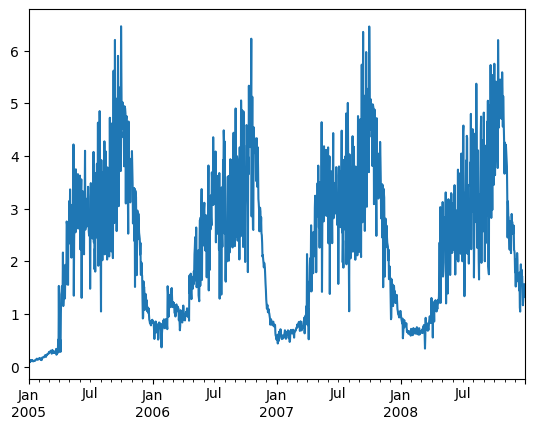

In [18]:
ET.dropna().plot()

### 2.3. Runoff <a class="anchor" id="t2_3"></a>

Use overlandsum PF output file (not CLM's). This file is written at PF output time steps (often daily), and any flow between these steps is cumulated so that this files records all the outflow over time across the domain boundary. **Only works for OverlandFlow**

Convert to mm

In [19]:
Q = ds1.overlandsum.isel(y=0).to_dataframe()['overlandsum']*1000/h['dx']/h['dy']/h['ny']

In [20]:
Q = Q.rename('Q')

### 2.4. Storage <a class="anchor" id="t2_4"></a>

In [21]:
storage = ds1.storage.sum(dim='y').to_dataframe()['storage']*1000/h['dx']/h['dy']/h['ny']
storage = storage - storage[0]

In [22]:
storage

time
2005-01-01      0.000000
2005-01-02     -0.094792
2005-01-03     -0.182953
2005-01-04     -0.265603
2005-01-05     -0.360058
                 ...    
2008-12-26    428.668403
2008-12-27    426.877394
2008-12-28    425.098333
2008-12-29    423.136865
2008-12-30    421.409269
Freq: D, Name: storage, Length: 1460, dtype: float64

### 2.5. Compute and plot <a class="anchor" id="t2_5"></a>


In [23]:
Budg = pd.DataFrame({'P':P.resample('Y').sum(),'ET':ET.resample('Y').sum(),'Q':Q.resample('Y').sum(),'WSC':np.nan})
for i, y in enumerate(np.sort(storage.index.year.unique())):
    if i ==0:
         Budg['WSC'][Budg.index.year==y] = storage[storage.index.year==y][-1]
    else:
         Budg['WSC'][Budg.index.year==y] = storage[storage.index.year==y][-1] - storage[storage.index.year==y-1][-1] 
Budg.index=Budg.index.year
Budg['closure'] = Budg['P']- Budg['ET']-Budg['Q']-Budg['WSC']
Budg

P          ET           Q         WSC       closure
2005  1213.8912  792.347415   97.336934  324.311791 -1.049402e-01
2006   913.0176  799.691392  141.324479  -27.998272  3.297926e-07
2007  1213.8912  882.216494  235.732430   95.942275  4.738766e-07
2008  1210.6476  869.362682  312.131443   29.153474  4.687353e-07
2009  1495.9260    0.000000         NaN         NaN           NaN
2010  1527.1380    0.000000         NaN         NaN           NaN
2011   934.3242    0.000000         NaN         NaN           NaN
2012  1422.4896    0.000000         NaN         NaN           NaN
2013   994.7970    0.000000         NaN         NaN           NaN
2014  1151.8704    0.000000         NaN         NaN           NaN
2015  1290.2922    0.000000         NaN         NaN           NaN

In [24]:
from matplotlib import pyplot as plt
def plot_clustered_stacked(dfall, labels=None,  H="/", axe=None, **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    fig = plt.figure(figsize=(10,4))
    if not axe:
        axe = fig.add_subplot(111)

    for df in dfall : # for each data frame
        if isinstance(df, pd.DataFrame):
            axe = df.plot(kind="bar",
            linewidth=0,
            stacked=True,
            ax=axe,
            legend=False,
            grid=False,
            **kwargs)  # make bar plots
        else:
             axe = df.plot(kind="bar",
             linewidth=0,
             stacked=True,
             ax=axe,
             legend=False,
             grid=False,
	     color='b',
             **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe


In [25]:
Budg.dropna(inplace=True)

Text(0, 0.5, 'mm')

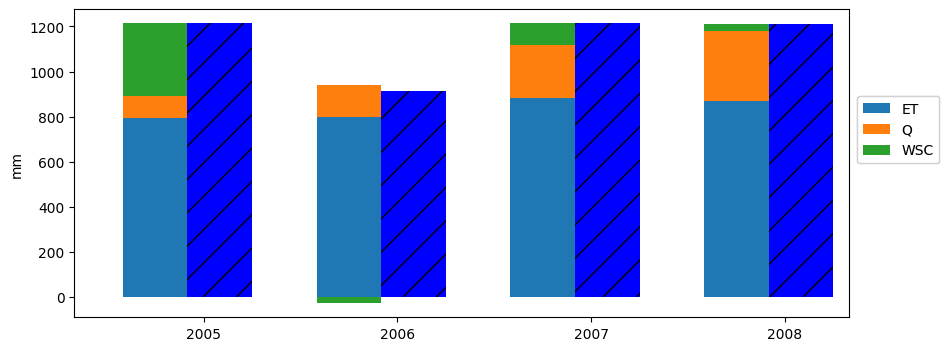

In [26]:
ax=plot_clustered_stacked([Budg.loc[:,['ET','Q','WSC']],Budg['P']])
ax.set_ylabel('mm')

## 3. Compute energy budget <a class="anchor" id="t3"></a>

In [27]:
dc1.lh_tot.mean(dim='y').resample(time='M').mean().to_dataframe().iloc[:,1]

time
2005-01-31      3.257791
2005-02-28      5.114377
2005-03-31      9.172379
2005-04-30     46.215725
2005-05-31     85.007535
2005-06-30     84.837784
2005-07-31     84.828944
2005-08-31     83.813058
2005-09-30    116.655643
2005-10-31    121.162223
2005-11-30     77.701585
2005-12-31     32.117123
2006-01-31     20.870993
2006-02-28     31.417231
2006-03-31     29.730542
2006-04-30     35.215642
2006-05-31     63.237652
2006-06-30     81.663937
2006-07-31     90.038644
2006-08-31     86.390353
2006-09-30    101.002508
2006-10-31    118.366396
2006-11-30     78.679309
2006-12-31     25.855277
2007-01-31     16.944716
2007-02-28     18.578347
2007-03-31     24.432702
2007-04-30     59.906760
2007-05-31     94.887237
2007-06-30     93.453235
2007-07-31     89.674779
2007-08-31     85.023944
2007-09-30    118.194277
2007-10-31    122.551276
2007-11-30     76.588375
2007-12-31     35.889337
2008-01-31     21.455456
2008-02-29     19.436208
2008-03-31     21.991481
2008-04-30     39.26

In [28]:
dc1 = dc1.assign(Rn = lambda x: x.lh_tot+ x.sh_tot +x.soil_grnd)
dc1 = dc1.assign(swrad_out = lambda x: x.Rn - x.lwrad_out)

def resample_extract(x,method='M'): return x.mean(dim='y').resample(time=method).mean().to_dataframe().iloc[:,1]
method='M'
Ebudg = pd.DataFrame({'LE':resample_extract(dc1.lh_tot,method),
                     'H':resample_extract(dc1.sh_tot,method),
                     'G':resample_extract(dc1.soil_grnd,method),
                     'Rn':resample_extract(dc1.Rn,method),                      
                     'SWout':resample_extract(dc1.swrad_out,method),
                     'LWout':resample_extract(dc1.lwrad_out,method)})


Text(0, 0.5, '$W.m^{-2}$')

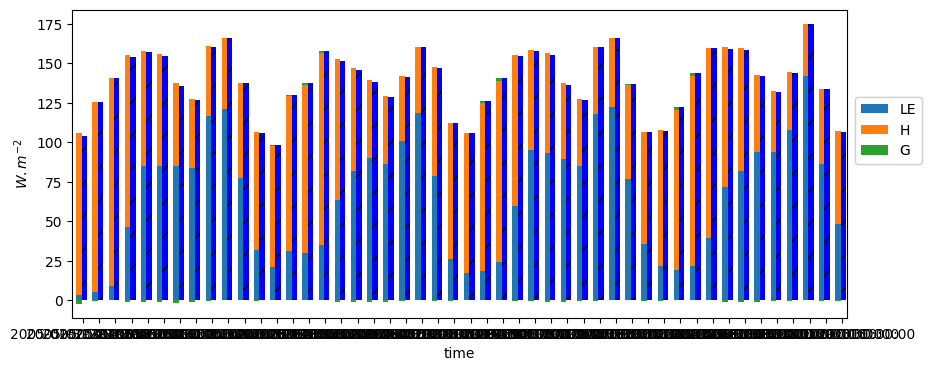

In [29]:
ax=plot_clustered_stacked([Ebudg.loc[:,['LE','H','G']],Ebudg['Rn']])
ax.set_ylabel('$W.m^{-2}$')

In [30]:
def resample_extract_downhill(x,method='M'): return x.isel(y=0).resample(time=method).mean().to_dataframe().iloc[:,-1]
def resample_extract_uphill(x,method='M'): return x.isel(y=-1).resample(time=method).mean().to_dataframe().iloc[:,-1]
method='M'
Ebudg_downhill = pd.DataFrame({'LE':resample_extract_downhill(dc1.lh_tot,method),
                     'H':resample_extract_downhill(dc1.sh_tot,method),
                     'G':resample_extract_downhill(dc1.soil_grnd,method),
                     'Rn':resample_extract_downhill(dc1.Rn,method),                      
                     'SWout':resample_extract_downhill(dc1.swrad_out,method),
                     'LWout':resample_extract_downhill(dc1.lwrad_out,method)})
Ebudg_uphill = pd.DataFrame({'LE':resample_extract_uphill(dc1.lh_tot,method),
                     'H':resample_extract_uphill(dc1.sh_tot,method),
                     'G':resample_extract_uphill(dc1.soil_grnd,method),
                     'Rn':resample_extract_uphill(dc1.Rn,method),                      
                     'SWout':resample_extract_uphill(dc1.swrad_out,method),
                     'LWout':resample_extract_uphill(dc1.lwrad_out,method)})


Text(0.5, 0, 'M')

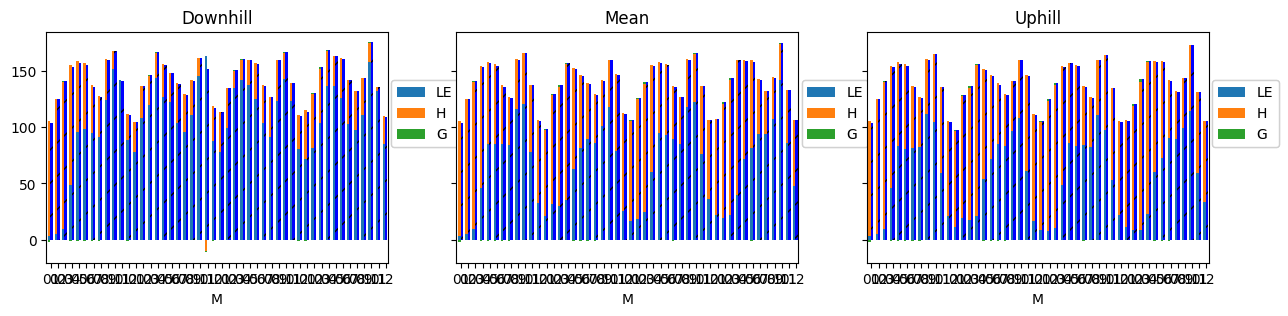

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

In [31]:
fig, ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(15,3))

#left: downhill
plot_clustered_stacked([Ebudg_downhill.loc[:,['LE','H','G']],Ebudg_downhill['Rn']],axe=ax[0])
ax[0].title.set_text('Downhill')
ax[0].set_xticklabels([item.get_text().split('-')[1] for item in ax[0].get_xticklabels()])
ax[0].set_xlabel(method)

#center: mean
plot_clustered_stacked([Ebudg.loc[:,['LE','H','G']],Ebudg['Rn']],axe=ax[1])
ax[1].title.set_text('Mean')
ax[1].set_xticklabels([item.get_text().split('-')[1] for item in ax[1].get_xticklabels()])
ax[1].set_xlabel(method)


#right: uphill
plot_clustered_stacked([Ebudg_uphill.loc[:,['LE','H','G']],Ebudg_uphill['Rn']],axe=ax[2])
ax[2].title.set_text('Uphill')
ax[2].set_xticklabels([item.get_text().split('-')[1] for item in ax[2].get_xticklabels()])
ax[2].set_xlabel(method)




In [32]:
def extract(x): return x.mean(dim='y').to_dataframe().iloc[:,1]
tmp = pd.concat([extract(dc1.Rn),extract(dc1.lh_tot),extract(dc1.sh_tot),
           extract(dc1.soil_grnd)],axis=1)
tmp2 = tmp.groupby(tmp.index.month).apply(lambda x: x.groupby(x.index.hour).mean())
tmp2.loc[1,:]
#tmp3 = tmp2.reset_index(0).rename(columns={'time':'month'})
#tmp4 = tmp3.melt(id_vars='month',value_vars=('Rn','lh_tot','sh_tot','soil_grnd'),value_name='flux',ignore_index=False)

Rn     lh_tot      sh_tot  soil_grnd
time                                              
0     -56.879153   1.740486  -26.571922 -32.047717
1     -56.435770   1.745561  -26.920060 -31.261271
2     -57.279917   1.919659  -29.204441 -29.995136
3     -57.506261   1.956143  -30.190893 -29.271511
4     -58.055297   1.799241  -31.212445 -28.642093
5     -57.934456   1.724173  -30.637683 -29.020945
6     -53.800331   1.839332  -27.515278 -28.124385
7      18.893111   7.346345   12.328468  -0.781702
8     185.434172  16.504977  132.630703  36.298492
9     352.988118  28.823860  256.593244  67.571014
10    476.633139  40.197555  352.542821  83.892762
11    544.590270  48.969328  407.174408  88.446534
12    549.360180  52.542860  416.829044  79.988276
13    489.372606  50.612625  378.198671  60.561310
14    390.120048  45.515659  307.962142  36.642247
15    241.501098  36.446504  194.914681  10.139913
16     68.799340  23.181032   53.447599  -7.829290
17    -75.510174   2.541654  -44.191418 -33.860410
18    -59.914908   1.441014  -20.136973 -41.218948
19    -57.649873   1.524110  -19.230070 -39.943913
20    -56.402060   1.516993  -19.936753 -37.982299
21    -58.558435   1.737143  -25.715735 -34.579843
22    -58.232160   1.737264  -26.636879 -33.332545
23    -57.798431   1.810223  -27.531361 -32.077294

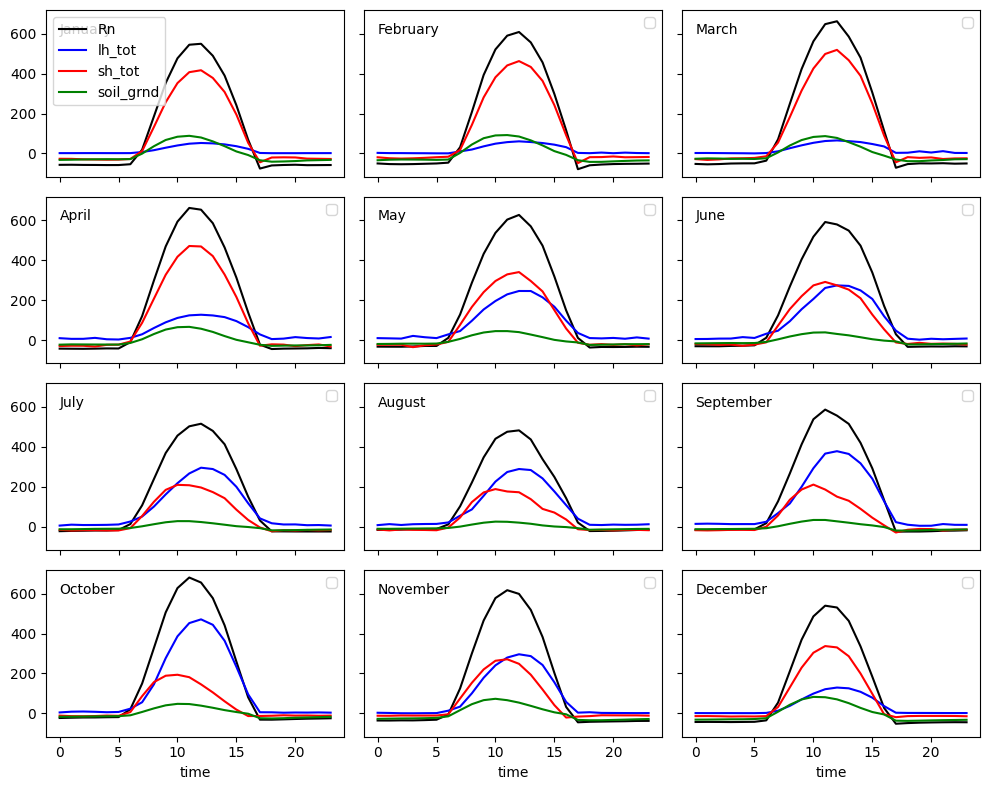

In [33]:
import calendar
fig, axes = plt.subplots(4,3,figsize=(10,8),squeeze=True,sharex=True,sharey=True)
for i,ax in enumerate(axes.flatten()):
    tmp2.loc[i+1,:].plot(ax=ax,color=['k','b','r','g'])
    if i>0:ax.legend([])
    ax.text(0,600,calendar.month_name[i+1])
plt.tight_layout()

# 4. Compute & plot ET <a class="anchor" id="t4"></a>

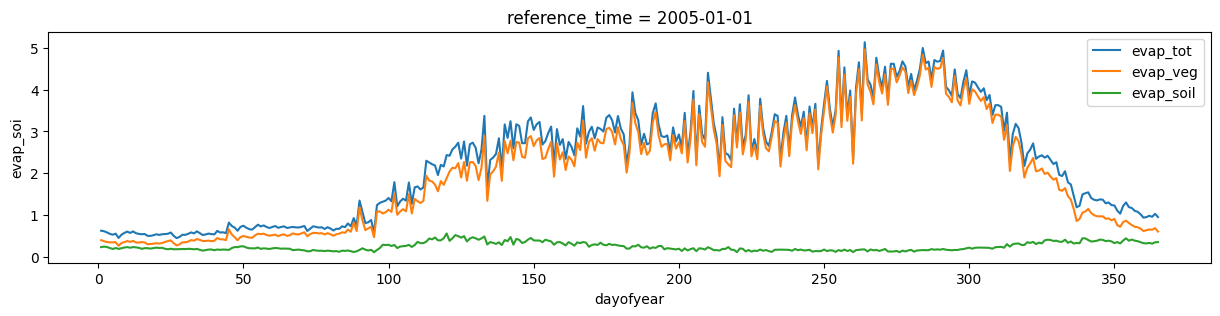

In [34]:
fig, ax = plt.subplots(figsize=(15,3))
dc1.evap_tot.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(label='evap_tot')
dc1.evap_veg.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(label='evap_veg')
dc1.evap_soi.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(label='evap_soil')
a = plt.gca()
a.legend()

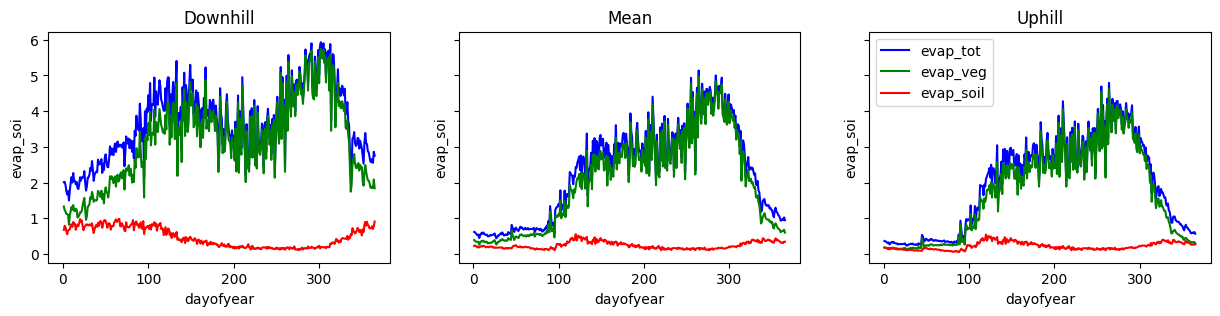

In [35]:
fig, ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(15,3))

#left: downhill
dc1.evap_tot.isel(y=0).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[0],label='evap_tot',color='b')
dc1.evap_veg.isel(y=0).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[0],label='evap_veg',color='g')
dc1.evap_soi.isel(y=0).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[0],label='evap_soil',color='r')
ax[0].title.set_text('Downhill')

#center: mean
dc1.evap_tot.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[1],label='evap_tot',color='b')
dc1.evap_veg.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[1],label='evap_veg',color='g')
dc1.evap_soi.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[1],label='evap_soil',color='r')
ax[1].title.set_text('Mean')


#right: uphill
dc1.evap_tot.isel(y=-1).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[2],label='evap_tot',color='b')
dc1.evap_veg.isel(y=-1).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[2],label='evap_veg',color='g')
dc1.evap_soi.isel(y=-1).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[2],label='evap_soil',color='r')
ax[2].title.set_text('Uphill')

a = plt.gca()
a.legend()

In [36]:
T = dc1.evap_veg.resample(time='D').sum().mean(dim='time')

In [37]:
E = dc1.evap_soi.resample(time='D').sum().mean(dim='time')

In [38]:
T_E = dc1.evap_veg.resample(time='D').sum().mean(dim='time') / dc1.evap_soi.resample(time='D').sum().mean(dim='time')

In [39]:
WTD_hillslope=ds1.WTD.mean(dim='time')

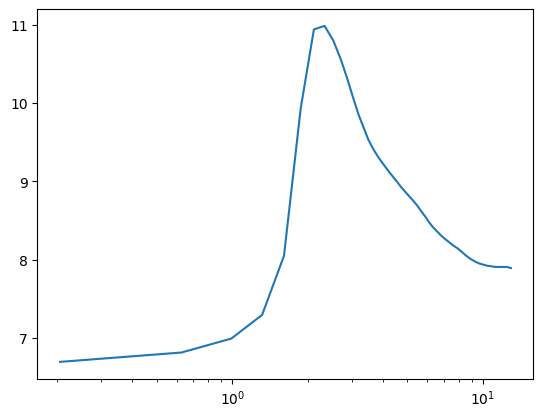

In [40]:
plt.semilogx(WTD_hillslope.data,T_E.data)

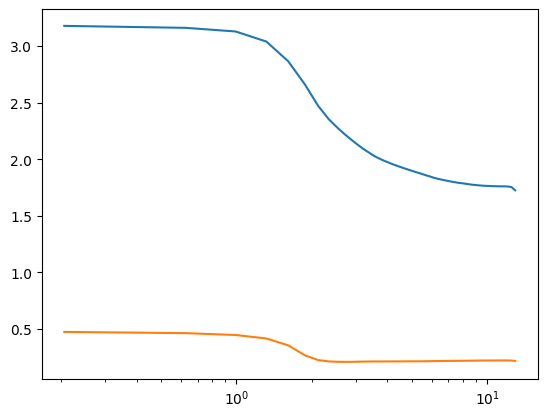

In [41]:
plt.semilogx(WTD_hillslope.data,T.data)
plt.semilogx(WTD_hillslope.data,E.data)

# 5. Compute & plot runoff <a class="anchor" id="t5"></a>

In [42]:
def calculate_OVFLOW(width,manning,slope,h):
    """
    simple function which return the overland flux from one cell to another across one cell
    """
    return (width/manning)*(slope**0.5)*h**(5./3.)


def calculate_runoff_from_press(htop,slopex,slopey,dx,dy,m):
    """
    compute runoff at single location
    htop dim is time
    """
    Sy = np.abs(slopey)
    Sx = np.abs(slopex)
    return np.where(htop>0,np.abs(calculate_OVFLOW(dy,m,Sx,htop))+np.abs(calculate_OVFLOW(dx,m,Sy,htop)),0)


In [43]:
manning = hill.Mannings.Geom.domain.Value
dc1 = dc1.assign(Q=lambda x: ('time',calculate_runoff_from_press(x.htop.data[:,0],
                                                         x.slopex.data[0],
                                                         x.slopey.data[0],
                                                         10,10,manning)))
dc1.Q.attrs['units']='m3/CLMtimestep'


/tmp/ipykernel_104872/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


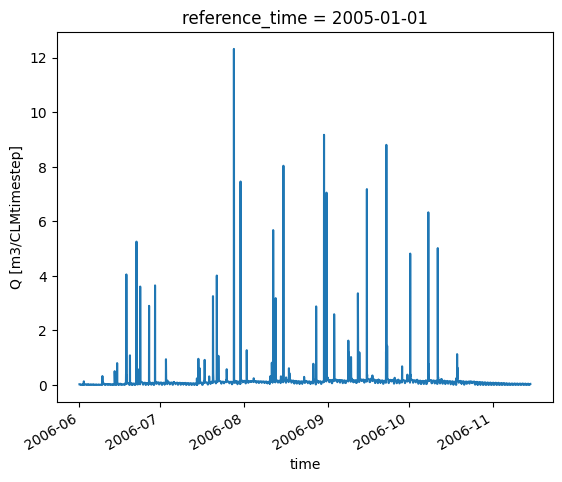

In [44]:
import datetime
dc1.Q.sel(time=slice(datetime.datetime(2006,6,1),datetime.datetime(2006,11,15))).plot()

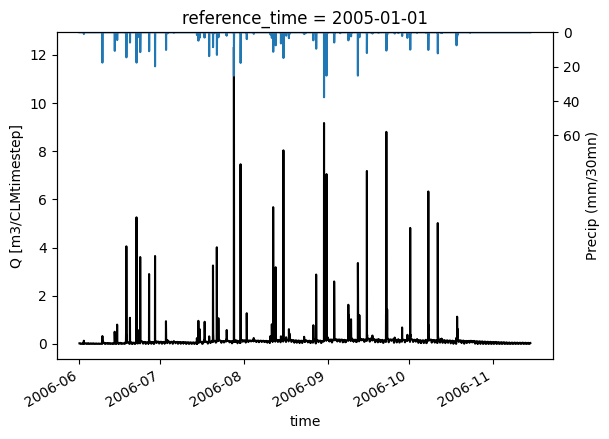

In [45]:
fig, ax = plt.subplots(1,1)
dc1.Q.sel(time=slice(datetime.datetime(2006,6,1),datetime.datetime(2006,11,15))).plot(ax=ax,color = 'k')
p1=ax.twinx() #declare second axis for precipitation
P.loc[(P.index>datetime.datetime(2006,6,1)) & (P.index<datetime.datetime(2006,11,15))].plot(ax=p1,x_compat=True)
p1.set_ylim([0,190])
p1.set_yticks([0,20,40,60])
p1.set_ylabel('Precip (mm/30mn)')
p1.invert_yaxis() # invert precipitation axis

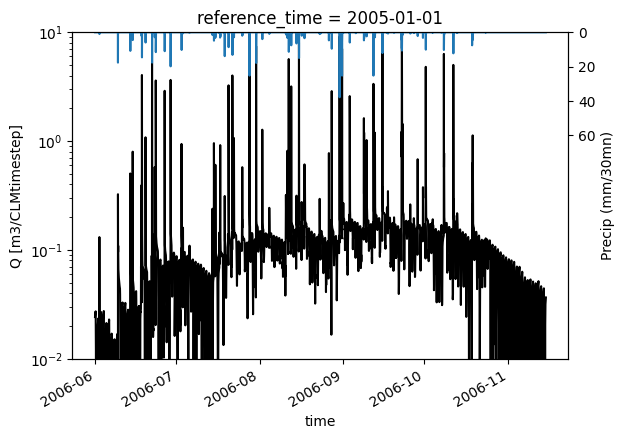

In [46]:
fig, ax = plt.subplots(1,1)
dc1.Q.sel(time=slice(datetime.datetime(2006,6,1),datetime.datetime(2006,11,15))).plot(yscale='log',ax=ax,color = 'k')
ax.set_ylim([0.01,10])
p1=ax.twinx() #declare second axis for precipitation
P.loc[(P.index>datetime.datetime(2006,6,1)) & (P.index<datetime.datetime(2006,11,15))].plot(ax=p1,x_compat=True)
p1.set_ylim([0,190])
p1.set_yticks([0,20,40,60])
p1.set_ylabel('Precip (mm/30mn)')
p1.invert_yaxis() # invert precipitation axis

# 6. Compute & plot WT <a class="anchor" id="t6"></a>

In [47]:
ds1.WTD.plot(x='time')

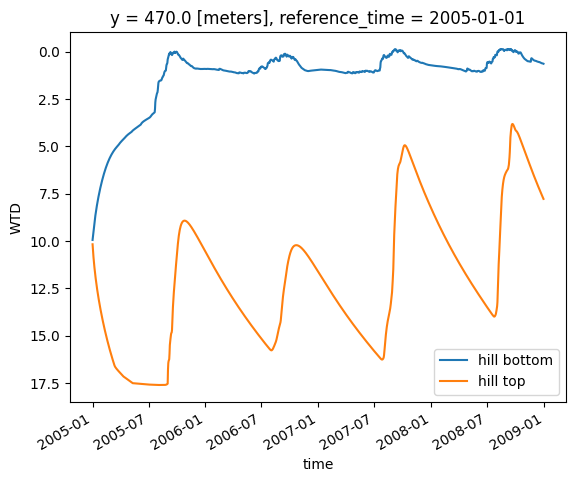

In [48]:
from matplotlib import pyplot as plt
ds1.WTD.isel(y=3).plot(label='hill bottom')
ds1.WTD.isel(y=47).plot(label='hill top')
plt.gca().legend()
plt.gca().invert_yaxis()

# 7. Compute & plot soil moisture <a class="anchor" id="t7"></a>

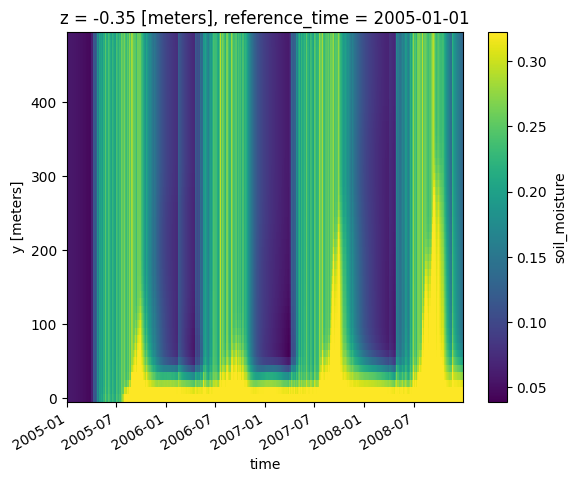

In [49]:
ds1.soil_moisture.isel(z=5).plot(x='time')

In [50]:
SM_uphill = ds1.soil_moisture.isel(y=-1).to_dataframe(dim_order=['time','z']).iloc[:,-1].unstack(1)
SM_downhill = ds1.soil_moisture.isel(y=3).to_dataframe(dim_order=['time','z']).iloc[:,-1].unstack(1)

In [51]:
#SM_uphill.plot(subplots=True, layout=(6,4),sharex=True,sharey=True)

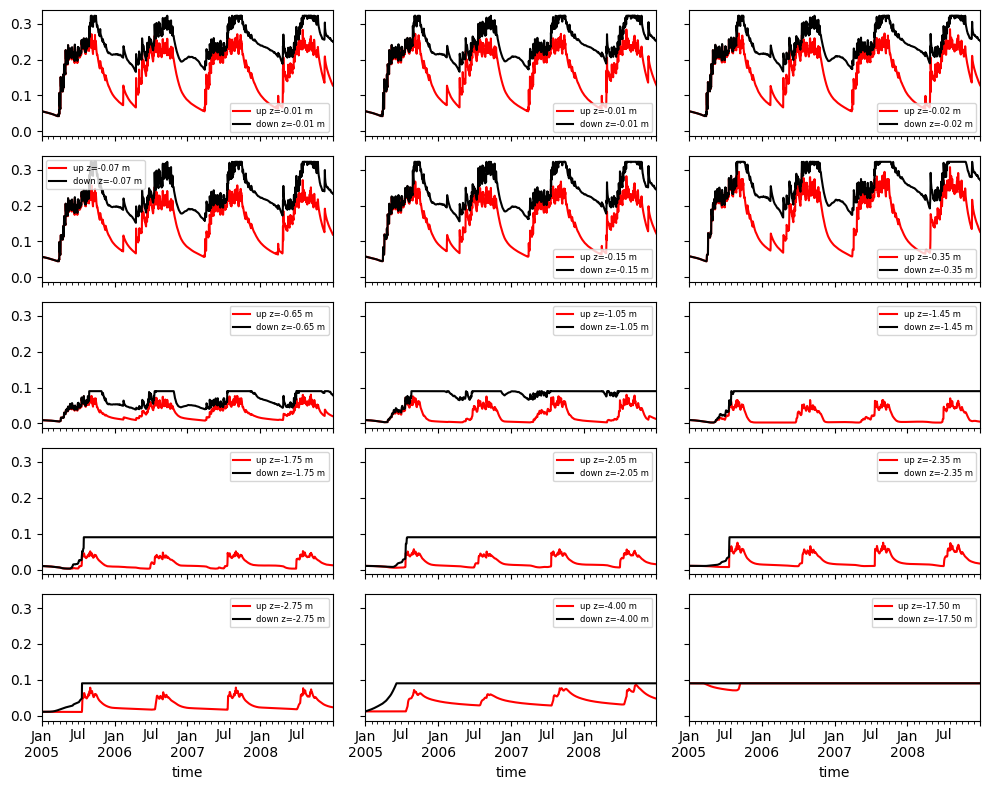

In [52]:
import calendar
fig, axes = plt.subplots(5,3,figsize=(10,8),squeeze=True,sharex=True,sharey=True)
for i,ax in enumerate(axes.flatten()):
    SM_uphill.iloc[:,i].plot(ax=ax,color='r',label = 'up z=%2.2f m'%float(SM_uphill.columns[i]))
    SM_downhill.iloc[:,i].plot(ax=ax,color='k',label = 'down z=%2.2f m'%float(SM_downhill.columns[i]))
    ax.legend(fontsize=6)
plt.tight_layout()

In [53]:
import hvplot.xarray
#interpolation optionnelle:
ds1tmp = ds1.interp(z=np.arange(0,-30,-0.2),method='linear')

#plot1 = ds1.satur.hvplot.quadmesh(x='y',y='z',groupby="time",clim=(0,1),widget_type="scrubber",widget_location="bottom")
plot1 = ds1tmp.satur.hvplot.quadmesh(x='y',y='z',groupby="time",clim=(0,1))
plot2 = (-ds1.WTD).hvplot.scatter(x='y',y='WTD',groupby='time',color='k')

plot1 * plot2

:DynamicMap   [time]
   :Overlay
      .QuadMesh.I :QuadMesh   [y,z]   (satur)
      .Scatter.I  :Scatter   [y]   (WTD)

# 8. Compute & plot water storage <a class="anchor" id="t8"></a>

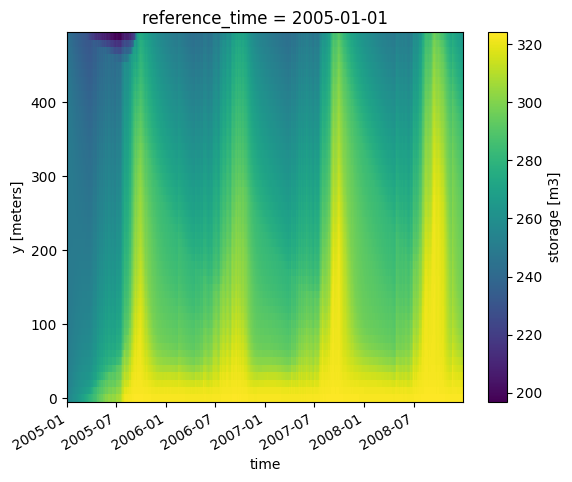

In [54]:
ds1.storage.plot(x='time')

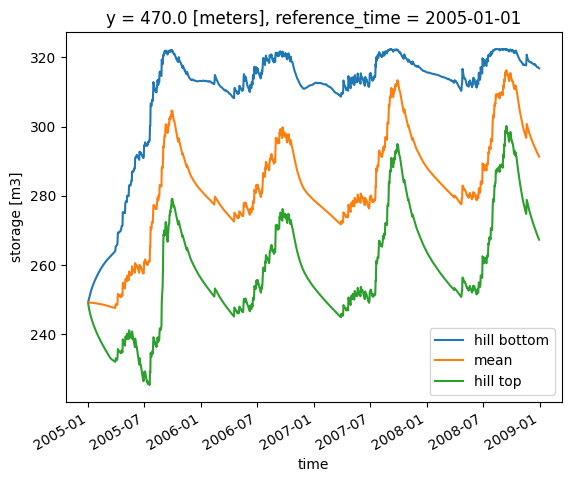

In [55]:
from matplotlib import pyplot as plt
ds1.storage.isel(y=3).plot(label='hill bottom')
ds1.storage.mean(dim='y').plot(label='mean')
ds1.storage.isel(y=47).plot(label='hill top')
plt.gca().legend()

# 9. Compute & plot retention curves <a class="anchor" id="t9"></a>

Some exemples to plot retention and conductivity curves... Modify at will to add other geometries

In [56]:
def calc_retention(h,thr,ths,hg,n):
    """
    """
    return thr+(ths-thr)*(1+(h/hg)**n)**(-(1-1/n))
    
    
def calc_cond(h,Ks,alpha,n):
    """
    """
    m=1-1/n
    return Ks*((1-((h*alpha)**(n-1))/((1+(h*alpha)**n)**m))**2)/((1+(h*alpha)**n)**(m/2))

Plot: 

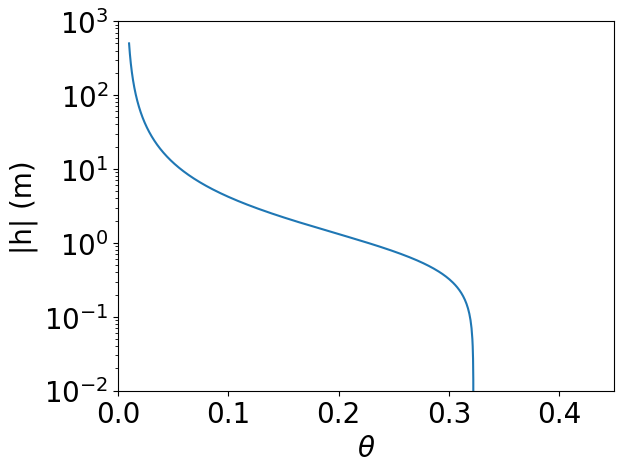

In [57]:
h=np.concatenate([np.arange(0.001,0.049,0.001),np.arange(0.05,1,0.01),np.arange(1.1,500,0.1)])        
th = calc_retention(h,thr = 
                    hill.Geom.H1.Porosity.Value*hill.Geom.H1.Saturation.SRes.value(),
                    ths= hill.Geom.H1.Porosity.Value*hill.Geom.H1.Saturation.SSat.value(),
                    hg= 1/hill.Geom.H1.Saturation.Alpha.value(),n = hill.Geom.H1.Saturation.N.value())

fig, ax = plt.subplots(1, 1)
ax.semilogy(th,h)
ax.set_xlim([0,0.45])
ax.set_ylim([0.01,1000])
#~ ax.legend((linesobs,linessim),['obs.','sim.'],loc='lower left',fontsize=28,ncol=1)
ax.set_ylabel('|h| (m)', fontsize=20, color = 'k')
ax.set_xlabel(r'$\theta$', fontsize=20, color = 'k')
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()


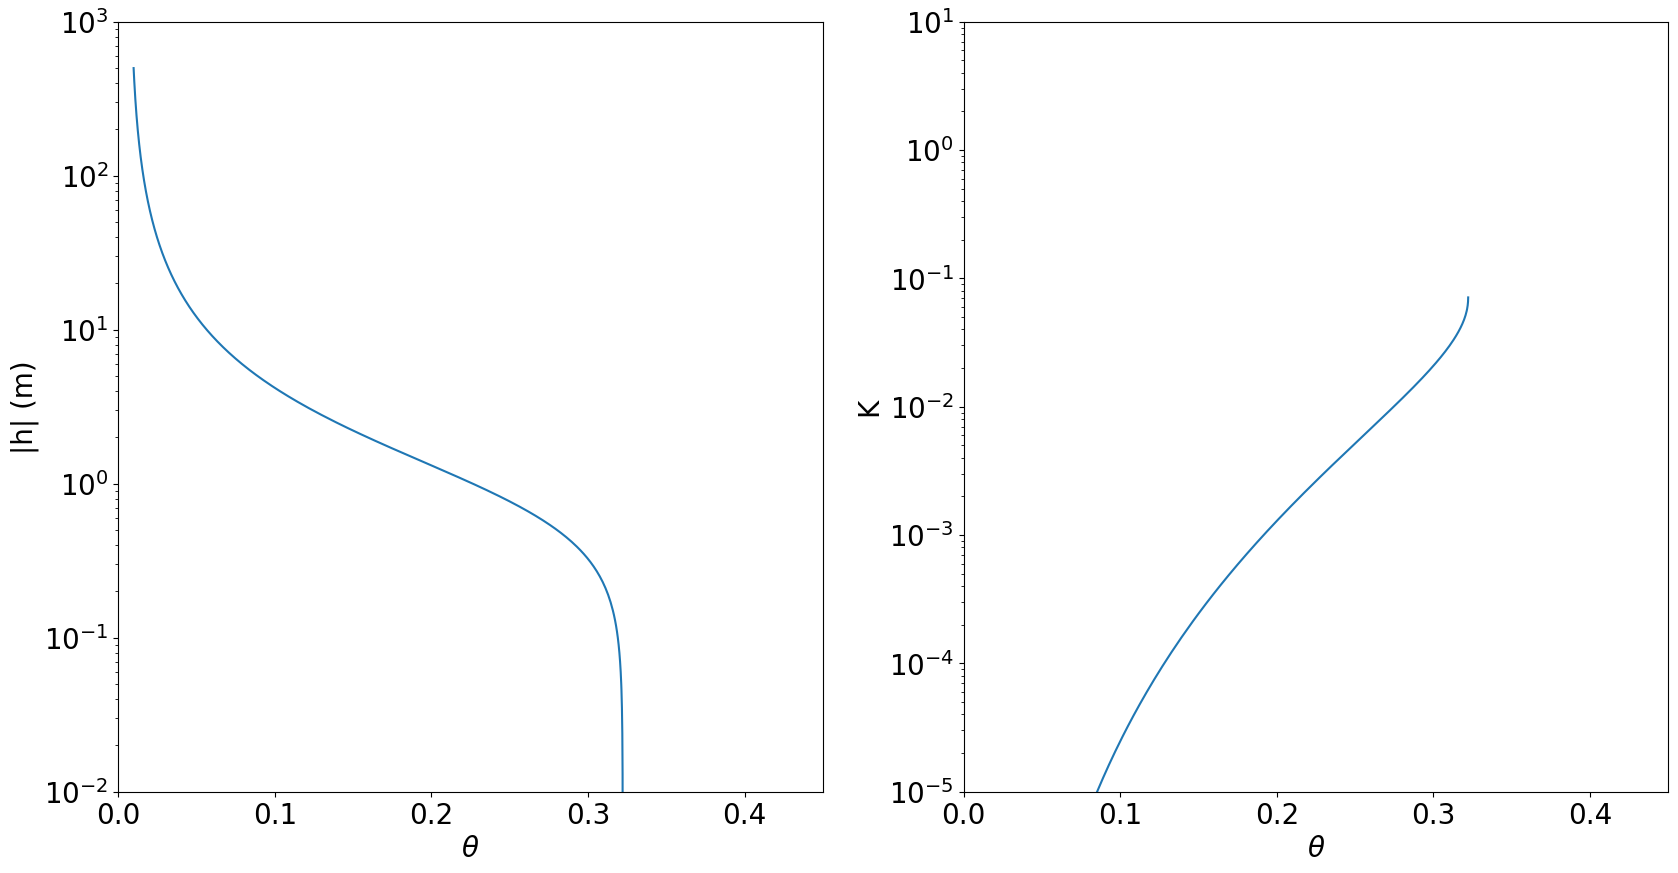

In [58]:
h=np.concatenate([np.arange(0.001,0.049,0.001),np.arange(0.05,1,0.01),np.arange(1.1,500,0.1)])        
th = calc_retention(h,thr = 
                    hill.Geom.H1.Porosity.Value*hill.Geom.H1.Saturation.SRes.value(),
                    ths= hill.Geom.H1.Porosity.Value*hill.Geom.H1.Saturation.SSat.value(),
                    hg= 1/hill.Geom.H1.Saturation.Alpha.value(),n = hill.Geom.H1.Saturation.N.value())

K = calc_cond(h,hill.Geom.H1.Perm.Value,
              alpha=hill.Geom.H1.Saturation.Alpha.value(),
              n = hill.Geom.H1.Saturation.N.value())
fig, ax = plt.subplots(1, 2,figsize=(20,10))
ax[0].semilogy(th,h)
ax[0].set_xlim([0,0.45])
ax[0].set_ylim([0.01,1000])
ax[0].set_ylabel('|h| (m)', fontsize=20, color = 'k')
ax[0].set_xlabel(r'$\theta$', fontsize=20, color = 'k')
ax[0].tick_params(axis='both', which='major', labelsize=20)

ax[1].semilogy(th,K)
ax[1].set_ylim([0.00001,10])
ax[1].set_xlim([0,0.45])
ax[1].set_ylabel('K', fontsize=20, color = 'k')
ax[1].set_xlabel(r'$\theta$', fontsize=20, color = 'k')
ax[1].tick_params(axis='both', which='major', labelsize=20)

plt.show()
